# Data Pre-processing

## A. Data Entry

In [5]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import utils
from scipy.stats import skew
import math
import re
from collections import deque

In [10]:
# load the data set
df = pd.read_csv("https://raw.githubusercontent.com/lavibula/ML20222.PredictionBitcoin/main/data/raw_data.csv")

In [11]:
df.head()

,Date,BTC_close,BTC_open,BTC_high,BTC_low,BTC_volume,BTC_change,difficulty,addresses_active_count,sum_block_weight,...,ETH,LTC,XRP,DOGE,COPPER,GOLD,SILVER,SPX,JP225,DJI
0,6/22/2023,29890.5,29992.8,30497.8,29590.4,79.22,-0.0035,52350439455487,1000988,547153915,...,1872.32,85.97,0.49401,0.065567,3.8900,1923.70,22.467,4381.89,33445.0,34210.0
1,6/21/2023,29996.9,28307.7,30769.5,28270.5,143.49,0.0597,52350439455487,920555,483181576,...,1889.87,85.12,0.49995,0.065644,3.9135,1944.90,22.810,4365.69,33390.0,34235.0
2,6/20/2023,28307.7,26845.9,28393.0,26665.5,100.55,0.0544,52350439455487,951926,543133484,...,1791.61,80.31,0.49270,0.063108,3.8835,1947.70,23.234,4388.71,33155.0,34356.0
3,6/19/2023,26845.9,26339.7,27029.7,26295.1,46.45,0.0192,52350439455487,920552,567091224,...,1737.06,77.51,0.49341,0.062429,3.8643,1964.05,24.062,NaN,NaN,NaN
4,6/18/2023,26339.7,26515.0,26679.3,26290.6,27.31,-0.0066,52350439455487,883864,603064705,...,1720.98,77.20,0.48699,0.062107,3.8738,1969.45,24.198,NaN,NaN,NaN


In [12]:
rows, cols = df.shape
print("There are {} rows.".format(rows))
print("There are {} columns.".format(cols))

There are 2661 rows.
There are 25 columns.


In [13]:
# check data type
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2661 entries, 0 to 2660
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    2661 non-null   object 
 1   BTC_close               2661 non-null   float64
 2   BTC_open                2661 non-null   float64
 3   BTC_high                2661 non-null   float64
 4   BTC_low                 2661 non-null   float64
 5   BTC_volume              2661 non-null   object 
 6   BTC_change              2661 non-null   float64
 7   difficulty              2661 non-null   int64  
 8   addresses_active_count  2661 non-null   int64  
 9   sum_block_weight        2661 non-null   int64  
 10  mean_block_size_bytes   2661 non-null   float64
 11  total_fees_usd          2661 non-null   float64
 12  mean_hash_rate          2661 non-null   float64
 13  xfer_cnt                2661 non-null   int64  
 14  mean_tx_size_usd        2661 non-null   

## B. Data Preprocessing

This section focuses on enhancing the data quality by finding the caveats of the data set and manipulating and dropping data before feeding them into the model's input pipeline. 
It also involves feature selection methods aimed at eliminating features that have the least impact on the target variable.

## 1. Evaluating Target Variables

Since the objective is to predict the price of Bitcoin, which is represented by the "BTC_close" variable, it is essential to ensure that "BTC_close" is valid for all records. 
Otherwise, if there are missing or invalid values in the "BTC_close" variable, it would result in the absence of a target variable for the predictive model.

In [14]:
df['BTC_close'].describe()

count     2661.000000
mean     16198.044645
std      16290.779916
min        408.200000
25%       4145.100000
50%       9310.800000
75%      23474.900000
max      67527.900000
Name: BTC_close, dtype: float64

In [15]:
print("Number of records with NULL price: ", df['BTC_close'].isna().sum())

Number of records with NULL price:  0


In [16]:
# collect the row indices where pice is NULL
price_isna_idx = np.where(df['BTC_close'].isna()==True)[0]
# remove the rows where target price is not available 
df.drop(price_isna_idx, axis=0, inplace=True)
print("Number of records with NULL price: ", df['BTC_close'].isna().sum())
print("-"*50)
rows, cols = df.shape
print("There are {} rows.".format(rows))
print("There are {} columns.".format(cols))

Number of records with NULL price:  0
--------------------------------------------------
There are 2661 rows.
There are 25 columns.


Before clipping the values of the target variables

Skewness:  1.2199621647733099


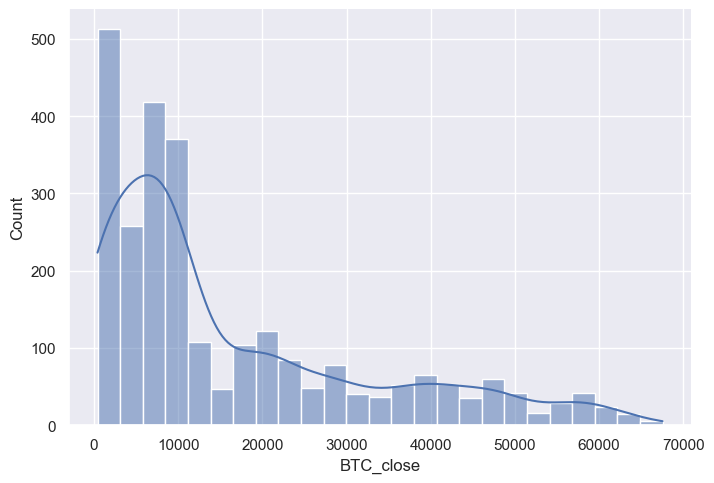

In [17]:
sns.set_theme()
price_dist = sns.displot(df['BTC_close'], kde=True)
price_dist.fig.set_size_inches(8,5)
print("Skewness: ", df['BTC_close'].skew())

?????? Các giá trị ngoại lai có thể mang thông tin quan trọng hoặc đại diện cho các biến động đặc biệt trong thị trường Bitcoin. Nếu xóa các giá trị này, có thể mất đi một phần quan trọng của thông tin và dẫn đến kết quả dự đoán không chính xác. => không xoá nhỉ
Lý do: 
1. Quan sát biến động cao: Giá Bitcoin có thể biến động mạnh và có những giai đoạn tăng giá đáng kể. Các giá trị ngoại lai có thể đại diện cho những biến động này và mang thông tin quan trọng về sự biến động của thị trường Bitcoin. Bằng cách giữ lại các giá trị ngoại lai, bạn có thể cho phép mô hình học hỏi và ứng phó với những biến động tương tự trong tương lai.

2. Quan tâm đến sự biến đổi đặc biệt: Các giá trị ngoại lai có thể đại diện cho các sự kiện đặc biệt hoặc các yếu tố độc đáo trong thị trường Bitcoin. Bằng cách giữ lại các giá trị này, bạn có thể cho phép mô hình nhận biết và tìm hiểu về các yếu tố đặc biệt này, giúp cải thiện khả năng dự đoán trong tương lai.

3. Tiềm năng lợi nhuận cao: Vì giá Bitcoin có thể tăng lên rất cao, việc giữ lại các giá trị ngoại lai có thể mang lại tiềm năng lợi nhuận cao trong trường hợp mô hình dự đoán chính xác các biến động này. Nếu bạn xóa các giá trị ngoại lai, bạn có thể mất đi cơ hội tận dụng những biến động giá trị Bitcoin tiềm năng.

4. Quan sát các xu hướng dài hạn: Bằng cách giữ lại các giá trị ngoại lai, bạn có thể giúp mô hình nhận biết và quan sát các xu hướng dài hạn của giá Bitcoin. Điều này có thể cung cấp thông tin giá trị về sự phát triển và tiềm năng tương lai của Bitcoin, giúp cải thiện khả năng dự đoán.

5. Tính chất đặc biệt của Bitcoin: Bitcoin có tính chất độc đáo và có thể trải qua các biến động rất lớn trong giá trị. Điều này có thể dẫn đến sự lệch trong biểu đồ khi các giá trị ngoại lai biểu thị những biến động này. Biểu đồ lệch có thể phản ánh tính chất không thường xuyên và không đồng nhất của dữ liệu Bitcoin.


## 2. Handling NULL Values

#### a. Dealing with the datetime feature

In [19]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')

#### b. NULL values

In [20]:
null_count_arr = df.isna().sum()
print(null_count_arr.sort_values(ascending=False))

DJI                       891
JP225                     891
SPX                       891
SILVER                    870
GOLD                      870
COPPER                    870
DOGE                      450
XRP                       450
LTC                       450
ETH                       450
xfer_cnt                    0
mean_tx_size_usd            0
Date                        0
BTC_close                   0
total_fees_usd              0
mean_block_size_bytes       0
sum_block_weight            0
addresses_active_count      0
difficulty                  0
BTC_change                  0
BTC_volume                  0
BTC_low                     0
BTC_high                    0
BTC_open                    0
mean_hash_rate              0
dtype: int64


Text(0.5, 1.0, 'Percentage of Missing Values by Features')

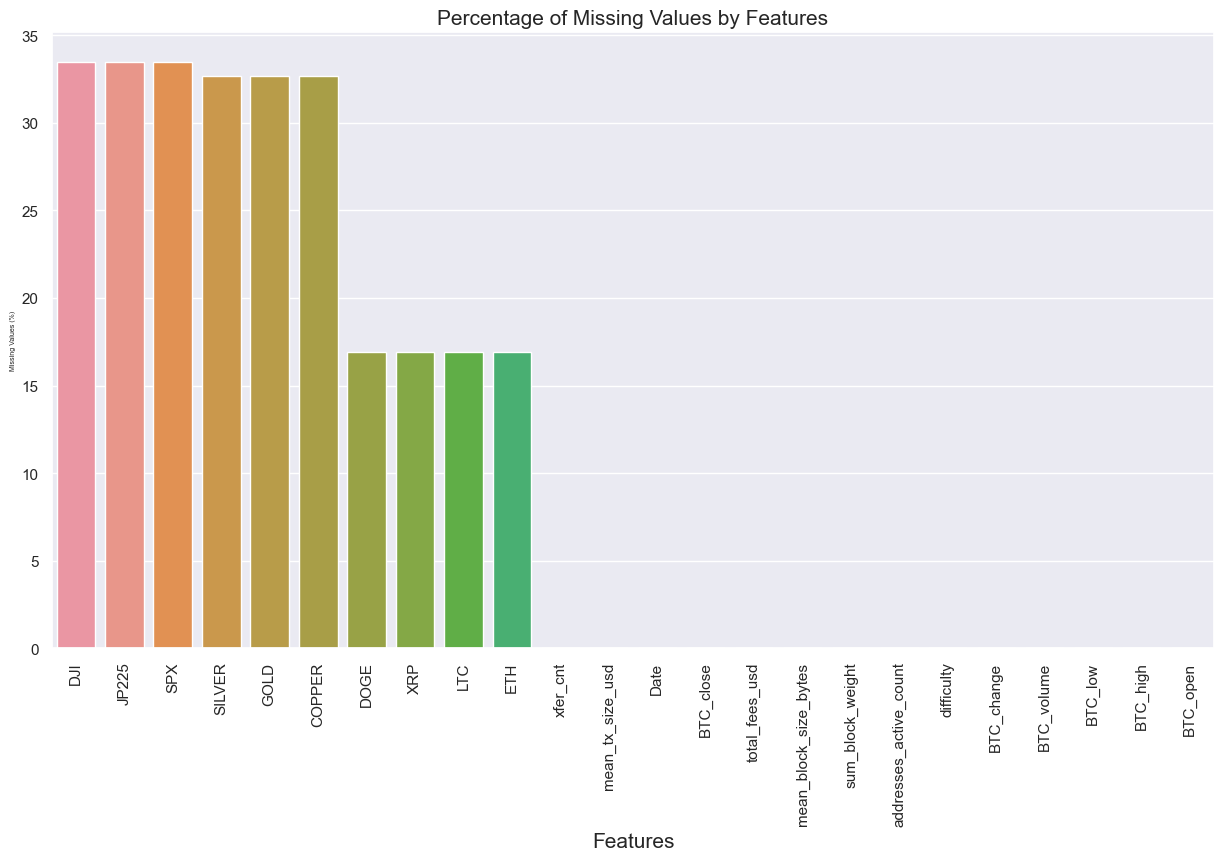

In [21]:
# plot the distribution of missing values by 24 features 
null_ratio = (null_count_arr.sort_values(ascending=False)[:24]/df.shape[0])*100
plt.figure(figsize=(15,8))
plt.xticks(rotation='vertical')
sns.barplot(x = null_ratio.index, y = null_ratio)
plt.xlabel('Features', fontsize = 15)
plt.ylabel('Missing Values (%)', fontsize = 5)
plt.title('Percentage of Missing Values by Features', fontsize = 15)

By observing the above information, we realize there are two problems with NULL data.

Firstly: Market Index including (S&P500, DJI, JP225) and Commodities (Gold, Silver, Copper) have no transactions on Saturday, and Sunday. If you look at our data set, they are all NULL on Saturdays and Sundays.

----> Solution: fill in the null value of Saturday, Sunday using the Friday of the last trading session of that week

Second: Other Cryptocurrencies (DOGE, LTC, ETH, XRP) have a NULL price because it is newly released later, specifically as follows:
XRP : 22/01/2015
ETH : 10/03/2016
LTC : April 28, 2016
DOGE : 03/06/2017
----> Solution: fill null value with 0 representing the non-occurrence

#### The first problem

In [22]:
# Get the earliest date by excluding missing values
earliest_date = df['Date'].dropna().min()

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    date = row['Date']
    # Check if the date value is missing (NaN)
    if pd.isnull(date):
        # Assign the earliest date to the missing value
        df.at[index, 'Date'] = earliest_date

In [23]:
df.head()

,Date,BTC_close,BTC_open,BTC_high,BTC_low,BTC_volume,BTC_change,difficulty,addresses_active_count,sum_block_weight,...,ETH,LTC,XRP,DOGE,COPPER,GOLD,SILVER,SPX,JP225,DJI
0,2023-06-22,29890.5,29992.8,30497.8,29590.4,79.22,-0.0035,52350439455487,1000988,547153915,...,1872.32,85.97,0.49401,0.065567,3.8900,1923.70,22.467,4381.89,33445.0,34210.0
1,2023-06-21,29996.9,28307.7,30769.5,28270.5,143.49,0.0597,52350439455487,920555,483181576,...,1889.87,85.12,0.49995,0.065644,3.9135,1944.90,22.810,4365.69,33390.0,34235.0
2,2023-06-20,28307.7,26845.9,28393.0,26665.5,100.55,0.0544,52350439455487,951926,543133484,...,1791.61,80.31,0.49270,0.063108,3.8835,1947.70,23.234,4388.71,33155.0,34356.0
3,2023-06-19,26845.9,26339.7,27029.7,26295.1,46.45,0.0192,52350439455487,920552,567091224,...,1737.06,77.51,0.49341,0.062429,3.8643,1964.05,24.062,NaN,NaN,NaN
4,2023-06-18,26339.7,26515.0,26679.3,26290.6,27.31,-0.0066,52350439455487,883864,603064705,...,1720.98,77.20,0.48699,0.062107,3.8738,1969.45,24.198,NaN,NaN,NaN


#### The second problem

In [24]:
# # Fill in the missing data with 0 value
df_filled = df.fillna(0)


In [25]:
# Check existence of NaN value in DataFrame
print("Is There any 'NaN' value: ", df_filled.isnull().values.any())

# Check existence of duplicate values in DataFrame
print("Is there any duplicate value: ", df_filled.index.duplicated().any())


Is There any 'NaN' value:  False
Is there any duplicate value:  False


## 3. Correlation Analysis

In [28]:
ds = df.set_index('Date') 
sns.heatmap(ds.corr(), cmap="RdBu")

ValueError: could not convert string to float: '1.04B'

In [27]:
# Retrieve the number of categorical fields and numerical fields
# field indices where column is categorical
categorical_col_idx = np.where(ds.dtypes == object)[0]
# field indices where column is numerical
numerical_col_idx = np.where(ds.dtypes != object)[0]
print("Number of categorical fields: ",categorical_col_idx.shape[0])
print("Number of numerical fields: ",numerical_col_idx.shape[0])

Number of categorical fields:  1
Number of numerical fields:  23


## 4. Finding outliers

In [ ]:
continuous_features = df.drop("Date", axis=1).columns.tolist()

In [ ]:
for feature in continuous_features:
    df_copy = df.copy()
    df_copy[feature] = np.log1p(df_copy[feature])
    df_copy.boxplot(column=feature)
    plt.ylabel(feature)
    plt.show()

## 5. Feature Engineering

#### a. Preparing X and y to do train test split

In [ ]:
X = df_filled.iloc[:, 1:]
y = df_filled.iloc[:, 0]
print(X.shape, y.shape)

#### b. The sample of the training and test files for the models

###### IF the way you divide is to use the date call to meet the set ratio

Train, Test = 85, 15

In [ ]:
"""from datetime import datetime

for index in total.index:
    total.loc[index, "Date"] = datetime.strptime(str(total.loc[index, "Date"])[:10], '%Y-%m-%d').date()

Start_day = date(2016, 3, 10)
Test_day = date(2022,3,1)
End_day = date(2023,4,16)


# train, test
total = total[(total["Date"] >= Start_day) & (total["Date"] <= End_day)].reset_index(drop = True)
train_dataset = total[total["Date"] < Test_day].reset_index(drop = True)
test_dataset = total[total["Date"] >= Test_day].reset_index(drop = True)"""

In [ ]:
"""X_train = train_dataset.drop(["Date"], axis=1)[:-1]
y_train = train_dataset["BTC_close"][1:].reset_index(drop=True)

X_test = test_dataset.drop(["Date"], axis=1)[:-1]
y_test = test_dataset["BTC_close"][1:].reset_index(drop=True)"""

In [ ]:
"""test_ratio = len(test_dataset) / len(total)

print("Test_data/total:", test_ratio)"""

In [ ]:
"""print("X_train size:", X_train.shape)
print("Y_train size:", y_train.shape)
print("X_test size:", X_test.shape)
print("Size y_test:", y_test.shape)"""

###### IF the way you split is to use train_test_split from Sklearn library



Train, Valid, Test = 70,15,15

In [ ]:
"""from sklearn.model_selection import train_test_split"""

In [ ]:
"""X_train, X_test, y_train, y_testn = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)"""

## 6. Feature Selection

Using the "Extra Trees Regressor" tool of the Scikitlearn library to create a graph that visually shows the importance of the independent variables X to the dependent variable Y in the forecasting model

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

feat_selection = ExtraTreesRegressor()
feat_selection.fit(X,y)

In [ ]:
print(feat_selection.feature_importances_)

In [ ]:
#plot a graph of feature importances
feat_importances = pd.Series(feat_selection.feature_importances_, index=X.columns)
feat_importances.nlargest(23).plot(kind='barh')
plt.show()

But for our case the number of features are less and our purpose so we will use all of them.

## 7. Feature Scaling

## C. Finishing Touch

In [ ]:
# save preprocessed data in .csv format for model building
#df_filled.to_csv('data.csv', index=False)